# 📊**Ninjacart CV Classification**

## 📝 **Metadata**

**Notebook Title:** Ninjacart CV Classification  
**Author:** Vishnu Vineeth P M

**Date Created:** April 2025   
**Tools Used:** Python, Pandas, tensorflow
**Objective:** The objective is to develop a program that can recognize the vegetable item(s) in a photo and identify them for the user.

#📈 Introduction

Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.

# 📚Importing the dataset

In [ ]:
! gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=06d8ac95-035f-4d64-b7d6-fdac8b2ee7da
To: /content/ninjacart_data.zip
100% 275M/275M [00:05<00:00, 54.4MB/s]


In [ ]:
#unzipping the folder
!unzip -q /content/ninjacart_data.zip

# 📚**Importing necessary libraries**

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import glob
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')

To count the total number of classes and images in it.

In [ ]:
class_dirs = os.listdir("/content/ninjacart_data/train") # list all directories inside "train" folder
image_dict = {}                                          # dict to store image array(key) for every class(value)
count_dict = {}                                          # dict to store count of files(key) for every class(value)
count_dict_test={}
size_list = list()
print('Total Classes : ',class_dirs)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/ninjacart_data/train/{cls}/*')
    #print(file_paths)
    count_dict[cls]=len(file_paths)
    images = np.random.choice(file_paths,size=(4,),replace=False)
    image_dict[cls] = [tf.keras.utils.load_img(img) for img in images]
    size_list.extend([tf.keras.utils.load_img(img).size for img in file_paths])
print('Training - Total Images : \n',count_dict)
#print('Test - Total Images :',len(test_ds))


for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/ninjacart_data/test/{cls}/*')
    count_dict_test[cls]=len(file_paths)

print('Test - Total Images : \n',count_dict_test)

Total Classes :  ['indian market', 'onion', 'potato', 'tomato']
Training - Total Images : 
 {'indian market': 599, 'onion': 849, 'potato': 898, 'tomato': 789}
Test - Total Images : 
 {'indian market': 81, 'onion': 83, 'potato': 81, 'tomato': 106}


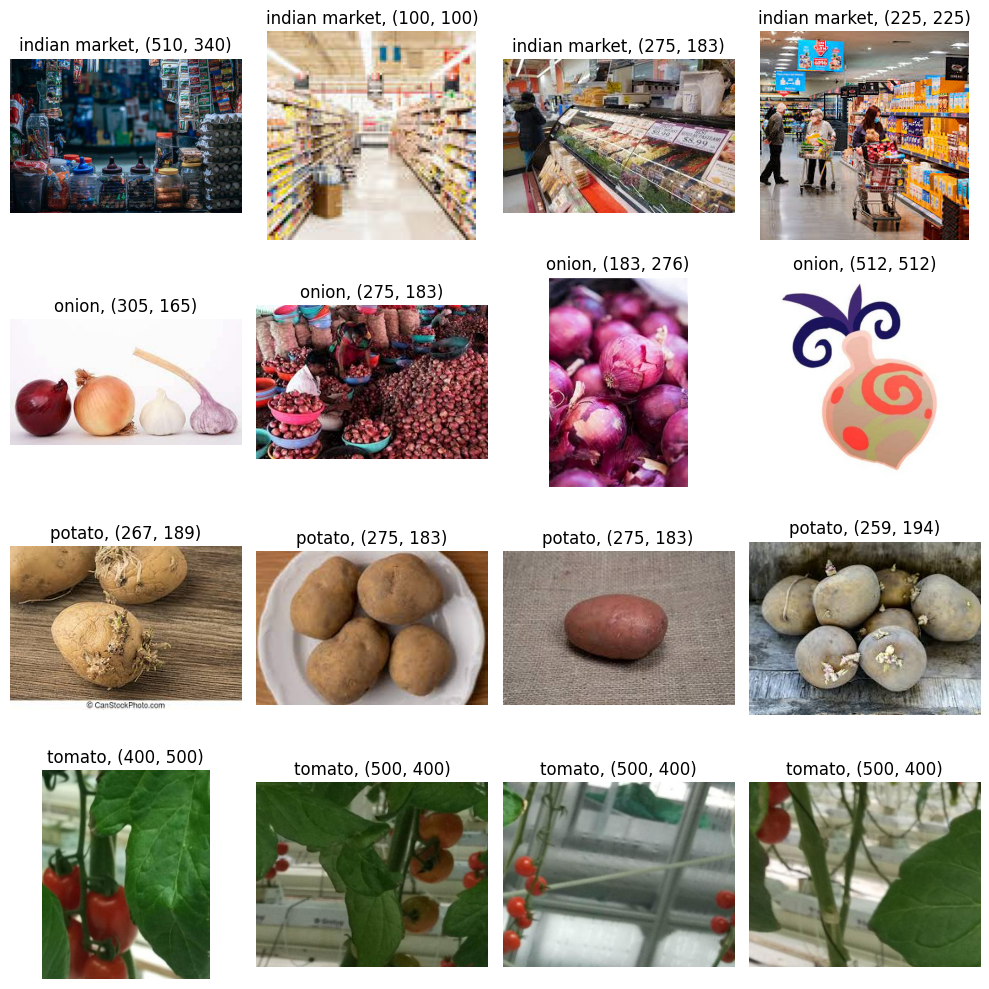

In [ ]:
#sample images
plt.figure(figsize=(10,10))

for i,(cat,images) in enumerate(image_dict.items()):
    for j,img in enumerate(images):
        plt.subplot(4,4,4*i+j+1)
        plt.imshow(img)
        plt.title(f"{cat}, {img.size}")
        plt.axis('off')
plt.tight_layout()
plt.show()

#### Insights
- The images of tomato are very vague. In some images, tomato is barely visible. So probably the neural network will learn how the leaves look and predict whether it is tomato or not.
- In some of the onion images, the onions looks like potato due to their color. So it might be confusion for the network to distinguish between potato and onion for these kind of images.
- Some of the market images contains vegetables. If these vegetables are either potato, tomato or onion, the network is going to have a hard time distinguishing them.

## **Exploratory Data Analysis (EDA)**

### Count of images

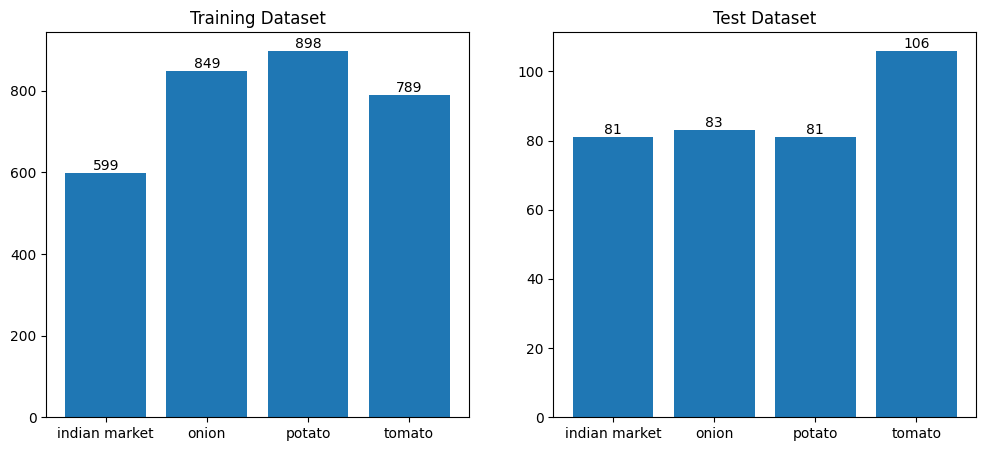

In [ ]:
plt.figure(figsize=(12, 5))

# Plot for Training Dataset
plt.subplot(121)
ax1 = plt.bar(count_dict.keys(), count_dict.values())
plt.title('Training Dataset')

# Add labels to bars
for bar in ax1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             str(bar.get_height()), ha='center', va='bottom')

# Plot for Test Dataset
plt.subplot(122)
ax2 = plt.bar(count_dict_test.keys(), count_dict_test.values())
plt.title('Test Dataset')

# Add labels to bars
for bar in ax2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             str(bar.get_height()), ha='center', va='bottom')

plt.show()


#### Insights
- The count of images of each class is very close to each other
- The model can perform well without class balancing

### Size of images

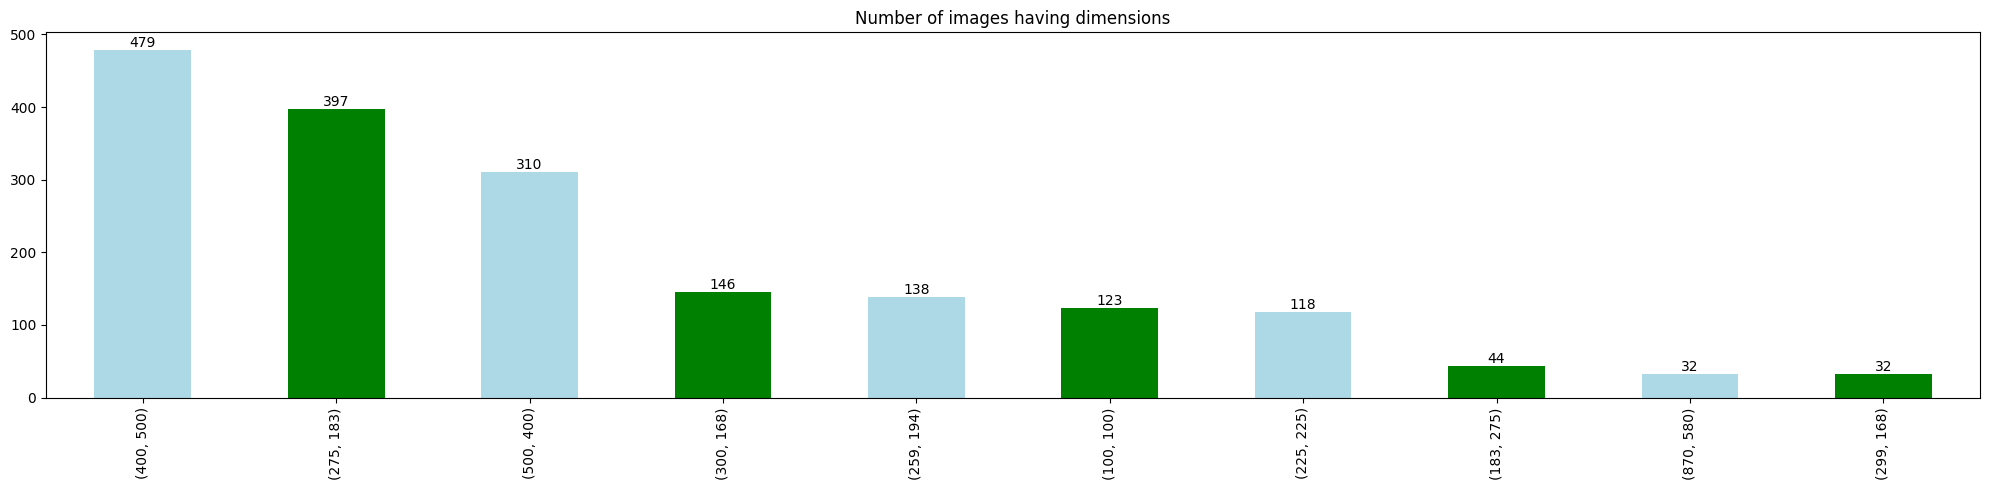

In [ ]:
plt.figure(figsize=(20,5))
ax = pd.Series(size_list).value_counts()[0:10].plot(kind='bar',x='dimension',y='count', color = ["lightblue","green"])
ax.bar_label(ax.containers[0])
plt.title('Number of images having dimensions')
plt.tight_layout()
plt.show()

#### Insights
- There are different sizes of images present in the dataset
- We need to resize each images before feeding it to the model


Before fitting data to our model, we must make sure that each image is
square-shaped so that we may resize it to the required dimensions and also
perform rescaling which will rescale the inputs between 0-1 by dividing each value by 255.

In [ ]:
#image size
image_size = (128, 128)
#training data split
train_ds,val_ds=tf.keras.utils.image_dataset_from_directory('/content/ninjacart_data/train',
                                                            label_mode = 'categorical',image_size = image_size,
                                                            validation_split=0.2,subset='both',shuffle=True,seed=42)

#testing data split
test_ds=tf.keras.utils.image_dataset_from_directory('/content/ninjacart_data/test',
                                                    label_mode = 'categorical',image_size = image_size)


#validation data
val_ds=tf.keras.utils.image_dataset_from_directory('/content/ninjacart_data/train',
                                                   label_mode = 'categorical', # Ensure 'categorical' mode for val_ds
                                                   image_size = image_size,validation_split=0.2,
                                                   subset='validation',shuffle=True,seed=42)

height,width=128,128

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Using 627 files for validation.
Found 351 files belonging to 4 classes.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.


In [ ]:
sample = next(iter(train_ds))[0]

print(sample)

tf.Tensor(
[[[[2.33950195e+01 3.39501953e+00 4.39501953e+00]
   [3.42993164e+01 8.57568359e+00 7.72949219e+00]
   [4.46215820e+01 1.26435547e+01 1.01030273e+01]
   ...
   [1.74638184e+02 1.63950684e+02 1.57794434e+02]
   [1.57635742e+02 1.48609375e+02 1.39653809e+02]
   [1.66792480e+02 1.57895020e+02 1.48843750e+02]]

  [[2.36645508e+01 4.60205078e+00 5.13330078e+00]
   [2.54062500e+01 3.21875000e+00 3.19580078e+00]
   [3.96806641e+01 9.34912109e+00 6.88037109e+00]
   ...
   [1.62939941e+02 1.54877441e+02 1.46808105e+02]
   [1.59061035e+02 1.50998535e+02 1.41546387e+02]
   [1.65397949e+02 1.58145508e+02 1.48348633e+02]]

  [[2.23500977e+01 6.42529297e+00 6.16894531e+00]
   [1.61630859e+01 6.83593750e-03 0.00000000e+00]
   [3.22485352e+01 5.45312500e+00 3.23437500e+00]
   ...
   [1.56915527e+02 1.52259277e+02 1.42196777e+02]
   [1.62873047e+02 1.58216797e+02 1.47435547e+02]
   [1.64912598e+02 1.60471680e+02 1.49618652e+02]]

  ...

  [[1.42227539e+02 4.05214844e+01 3.85214844e+01]
   [1

## **Model Building**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Let us create a script which can be used to evaluate our model

In [ ]:
def plot_accuracy(model_fit):
    #accuracy graph

    x = range(0,len(model_fit.history.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    #annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    #annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()



import seaborn as sns
def ConfusionMatrix(model, ds, label_list):

    # generate confusion matrix and plot it
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

noise_path = '/content/ninjacart_data/test/indian market'
onion_path = '/content/ninjacart_data/test/onion'
potato_path = '/content/ninjacart_data/test/potato'
tomato_path = '/content/ninjacart_data/test/tomato'



def classwise_accuracy(class_path, class_name, model_name) :
    paths = []
    for i in os.listdir(class_path):
        paths.append(class_path + "/" + str(i))

    correct = 0
    total = 0

    for i in range(len(paths)):
        total += 1

        img = tf.keras.utils.load_img(paths[i])
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, (128, 128))
        img = tf.expand_dims(img, axis = 0)

        pred = model_name.predict(img,verbose=0)
        if tf.argmax(pred[0]) == class_name.index(f"{class_name}"):
            correct+= 1

    print(f"Accuracy for class {class_name} is {round((correct/total)*100, 2)}% consisting of {len(paths)} images")


def model_evaluation_acc(model_name):
  # Evaluate the model
  loss, acc = model_name.evaluate(test_ds, verbose=2)
  print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

  y_pred = model_name.predict(test_ds)
  predicted_categories = tf.argmax(y_pred, axis=1)
  true_cat = tf.concat([y for x, y in test_ds], axis=0)
  true_categories = tf.argmax(true_cat, axis=1)

  # calculate accuracy
  test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
  print(f'\nTest Accuracy: {test_acc:.2f}%\n')

  classwise_accuracy(noise_path, 'noise', model_name)
  classwise_accuracy(onion_path, 'onion', model_name)
  classwise_accuracy(potato_path, 'potato', model_name)
  classwise_accuracy(tomato_path, 'tomato', model_name)

  ConfusionMatrix(model_name, test_ds, class_dirs)

Here we have created 4 evaluation functions :

1. **plot_accuracy(model_fit)**

  - Purpose: Plots training and validation accuracy over epochs.

  - How it works:

      - Extracts accuracy values from the model_fit.history.history dictionary.

      - Converts them into percentage format.

      - Plots training accuracy (y_train) and validation accuracy (y_val) against epochs.

      - Uses matplotlib to visualize the accuracy trend.


2. **ConfusionMatrix(model, ds, label_list)**

  - Purpose: Plots a confusion matrix for model predictions.

  - How it works:

    - Uses metrics.confusion_matrix from sklearn to compute the confusion matrix.

    - true_categories and predicted_categories (lists of actual vs. predicted labels) are used.

    - Uses seaborn (sns.heatmap()) to visualize the confusion matrix.

    - label_list is used for labeling the matrix.


3. **classwise_accuracy(class_path, class_name, model_name)**


  - Purpose: Computes accuracy for each class in the dataset.

  - How it works:

    - Reads image files from class_path.

    - Loads each image, resizes it to (128, 128), and converts it to a NumPy array.

    - Uses the trained model (model_name.predict()) to classify the image.

    - Compares the predicted label with the actual class index.

    - Computes and prints class-wise accuracy.


4. **model_evaluation_acc(model_name)**

  - Purpose: Evaluates the trained model on a test dataset and prints accuracy metrics.

  - How it works:

  - Evaluates model accuracy using model_name.evaluate(test_ds).

  - Predicts labels on test_ds and calculates the accuracy using sklearn.metrics.accuracy_score().

  - Calls classwise_accuracy() for individual class evaluation.

  - Calls ConfusionMatrix() to visualize performance.

### Building a base model

In [ ]:
cnn_model = tf.keras.Sequential(
    name='cnn_model',
    layers=[
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),

    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),

    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),

    layers.Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'),

    layers.GlobalAveragePooling2D(),
    layers.Dense(4, activation = 'softmax')
])
cnn_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=cnn_model.fit(train_ds,epochs=5,validation_data=val_ds)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.4203 - loss: 1.1513 - val_accuracy: 0.7081 - val_loss: 0.7271
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7507 - loss: 0.6651 - val_accuracy: 0.7544 - val_loss: 0.6179
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.7851 - loss: 0.5631 - val_accuracy: 0.7624 - val_loss: 0.5995
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8192 - loss: 0.5126 - val_accuracy: 0.7368 - val_loss: 0.7069
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.8216 - loss: 0.5180 - val_accuracy: 0.7863 - val_loss: 0.5427


In [ ]:
cnn_model.summary()

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 419,822 (1.60 MB)

 Trainable params: 139,940 (546.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 279,882 (1.07 MB)

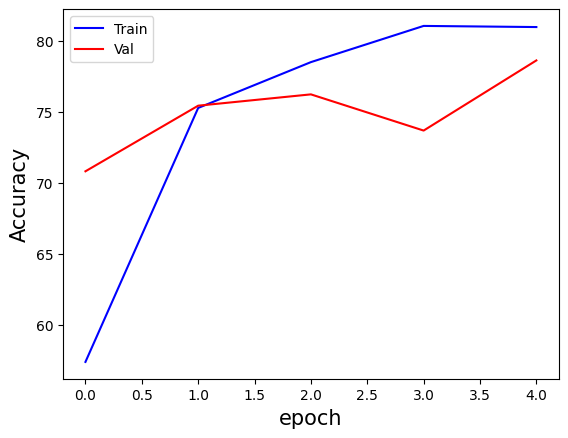

In [ ]:
#let us plot the accuray
plot_accuracy(cnn_model)

#### **Insights**

1. Steady Increase in Training Accuracy

  - The blue line (training accuracy) rises sharply from till the end(~82%.)

  - This indicates that the model is learning well from the training data.

2. Validation Accuracy Saturation

  - The red line (validation accuracy) also increases but does not show an improvement after 75% after epoch 3.

  - This suggests that the model is no longer improving on unseen data, possibly indicating early signs of overfitting.

3. Potential Overfitting

  - The training accuracy is significantly higher than validation accuracy in later epochs (~7% gap).

  - If this gap widens further, the model might be memorizing training data instead of generalizing well.

Inorder to improve the model we can try :

1. Early Stopping → Stop training if validation accuracy does not improve for a few epochs.
2. Regularization → Add dropout layers or L2 regularization to prevent overfitting.
3. Data Augmentation → Enhance training data with transformations to improve generalization.

11/11 - 2s - 189ms/step - accuracy: 0.7692 - loss: 0.5632
Restored model, accuracy: 76.92%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Test Accuracy: 23.93%

Accuracy for class noise is 70.37% consisting of 81 images
Accuracy for class onion is 13.25% consisting of 83 images
Accuracy for class potato is 20.99% consisting of 81 images
Accuracy for class tomato is 1.89% consisting of 106 images


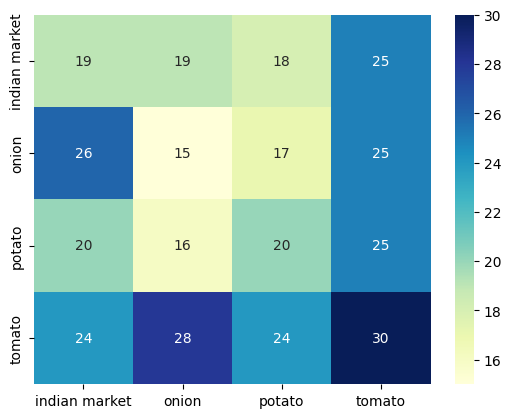

In [ ]:
loss, acc = cnn_model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

y_pred = cnn_model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_cat = tf.concat([y for x, y in test_ds], axis=0)
true_categories = tf.argmax(true_cat, axis=1)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

classwise_accuracy(noise_path, 'noise', cnn_model)
classwise_accuracy(onion_path, 'onion', cnn_model)
classwise_accuracy(potato_path, 'potato', cnn_model)
classwise_accuracy(tomato_path, 'tomato', cnn_model)

ConfusionMatrix(cnn_model, test_ds, class_dirs)

Let us visualize the model's prediction on the test images

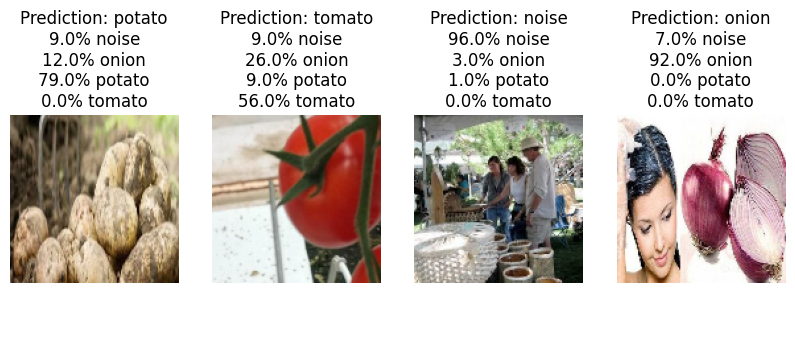

In [ ]:

test_dir = '/content/ninjacart_data/test'
test_images = []
class_names = ['noise', 'onion', 'potato', 'tomato']

for folder in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, folder)):
        test_images.append(os.path.join(test_dir, folder, image))

def grid_test_model(model_name):
    fig = plt.figure(figsize=(10, 4))
    plt.axis('off')

    for i in range(4):
        img_path = random.choice(test_images)
        img = tf.keras.utils.load_img(img_path)
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, (128, 128))
        img = tf.expand_dims(img, axis=0)

        pred = model_name.predict(img, verbose=0)
        predicted_label = tf.argmax(pred, axis=1).numpy().item()
        pred = tf.round(pred * 100).numpy().flatten()

        plt.subplot(1, 4, i + 1)
        plt.axis('off')
        plt.title(f'Prediction: {class_names[predicted_label]}\n'
                  f'{pred[0]}% {class_names[0]}\n'
                  f'{pred[1]}% {class_names[1]}\n'
                  f'{pred[2]}% {class_names[2]}\n'
                  f'{pred[3]}% {class_names[3]}')
        plt.imshow(img[0] / 255)

    plt.show()

grid_test_model(cnn_model)


Applying the data augmentation technique to the train dataset

In [ ]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor=0.2)
])

aug_ds = train_ds

for image, label in aug_ds :
  image = augmentation(image)

In [ ]:
#create an improvised cnn model
cnn_model_improved =keras.Sequential(
    name='cnn_model_improved',
    layers=[
    layers.Rescaling(1./255)

    ,layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=(128,128,3))
    #adding BatchNormalization
    ,layers.BatchNormalization()
    ,layers.MaxPooling2D()

    ,layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')
    ,layers.BatchNormalization()
    ,layers.MaxPooling2D()

    ,layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu')
    ,layers.BatchNormalization()
    ,layers.MaxPooling2D()

    ,layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu')
    ,layers.BatchNormalization()
    ,layers.MaxPooling2D()

    ,layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu')
    ,layers.BatchNormalization()
    ,layers.GlobalAveragePooling2D()
    #dropouts
    ,layers.Dropout(0.2)
    ,layers.Dense(4,activation='softmax')
])

cnn_model_improved.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=cnn_model_improved.fit(train_ds,epochs=20,validation_data=val_ds)



Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.6981 - loss: 0.7584 - val_accuracy: 0.2648 - val_loss: 2.3913
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8311 - loss: 0.4394 - val_accuracy: 0.2648 - val_loss: 4.0739
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8373 - loss: 0.4458 - val_accuracy: 0.2695 - val_loss: 3.0760
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8724 - loss: 0.3564 - val_accuracy: 0.5343 - val_loss: 1.0375
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.8724 - loss: 0.3249 - val_accuracy: 0.4944 - val_loss: 1.1426
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.8866 - loss: 0.3350 - val_accuracy: 0.7847 - val_loss: 0.4846
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8720 - loss: 0.3207 - val_accuracy: 0.7081 - val_loss: 1.0172
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.9009 - loss: 0.3024 - val_accuracy: 0.8

| **Feature**                  | **Initial CNN Model**               | **Improved CNN Model**                   | **Benefit**                                          |
|------------------------------|----------------------------------|-----------------------------------------|-----------------------------------------------------|
| **Batch Normalization**      | ❌ No                             | ✅ Yes (after each Conv2D layer)       | Faster convergence, reduces internal covariate shift |
| **Number of MaxPooling Layers** | 2                            | 4                                       | More progressive down-sampling and feature extraction |
| **Dropout**                  | ❌ No                             | ✅ Yes (0.2)                            | Helps prevent overfitting                            |
| **Training Epochs**          | 5                                | 20                                      | More training time, allowing better convergence     |


In [ ]:
cnn_model_improved.summary()

Model: "cnn_model_improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 422,382 (1.61 MB)

 Trainable params: 140,580 (549.14 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 281,162 (1.07 MB)

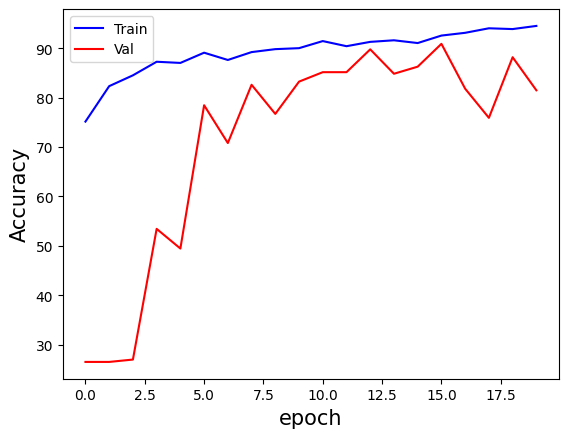

In [ ]:
#plotting the accuracy graph
plot_accuracy(cnn_model_improved)

1. Training Accuracy (Blue Line):

  - The training accuracy increases steadily and reaches above 90%.

  - There are no major fluctuations, indicating that the model is learning well on the training data.

2. Validation Accuracy (Red Line):

  - The validation accuracy improves initially but shows high fluctuations after around 7-8 epochs.

  - These sharp ups and downs suggest overfitting, where the model is performing well on the training data but struggling with unseen validation data.

11/11 - 1s - 132ms/step - accuracy: 0.7179 - loss: 0.8270
Restored model, accuracy: 71.79%
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step

Test Accuracy: 25.07%

Accuracy for class noise is 30.86% consisting of 81 images
Accuracy for class onion is 0.0% consisting of 83 images
Accuracy for class potato is 0.0% consisting of 81 images
Accuracy for class tomato is 0.0% consisting of 106 images


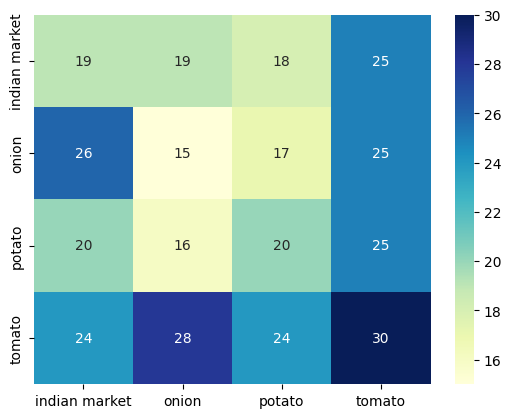

In [ ]:
#model evaluation
model_evaluation_acc(cnn_model_improved)

### **Insights**

We can see an accuracy increase due to:
- Applying augmentation to our data
- Adding Dropout and BatchNormalization
- Implementing callbacks during training

Use a model of our choice (could be vgg, resnet and mobilenet) and train it with an appropriate batch size.

Using the pretrained weights of popular networks is a great way to do
 transfer learning, since the size of our original dataset is small.

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 5, restore_best_weights=True
)

pretrained_model=tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
pretrained_model.trainable=False
VGG16_model=tf.keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4,activation='softmax')
    ])
VGG16_model.compile(optimizer='Adam', metrics=['accuracy'], loss='categorical_crossentropy')

history=VGG16_model.fit(train_ds,epochs=20,validation_data=val_ds,callbacks=[early_stopping_cb],verbose=0)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

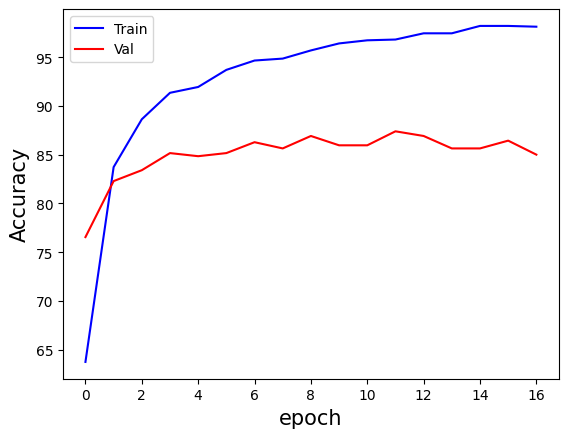

In [ ]:
plot_accuracy(VGG16_model)

#### **Insights**

1. Training Accuracy (Blue Line) → Keeps increasing (~98%)

  - The model is learning the training data very well.

2. Validation Accuracy (Red Line) → Plateaus (~85%)

  - Validation accuracy stops improving early and fluctuates slightly.

  - There's a gap between training and validation accuracy, indicating overfitting.

11/11 - 6s - 590ms/step - accuracy: 0.8205 - loss: 1.2276
Restored model, accuracy: 82.05%
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step

Test Accuracy: 23.08%

Accuracy for class noise is 81.48% consisting of 81 images
Accuracy for class onion is 2.41% consisting of 83 images
Accuracy for class potato is 4.94% consisting of 81 images
Accuracy for class tomato is 0.0% consisting of 106 images


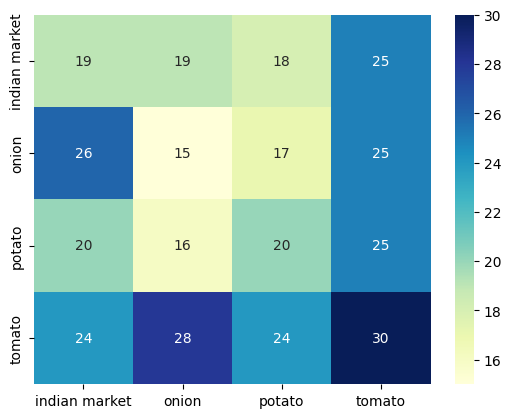

In [ ]:
model_evaluation_acc(VGG16_model)

In [ ]:
#VGG19 model
pretrained_model=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
pretrained_model.trainable=False
VGG19_model=tf.keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4,activation='softmax')
    ])
VGG19_model.compile(optimizer='Adam', metrics=['accuracy'], loss='categorical_crossentropy')

history=VGG19_model.fit(aug_ds,epochs=20,validation_data=val_ds,verbose=0)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

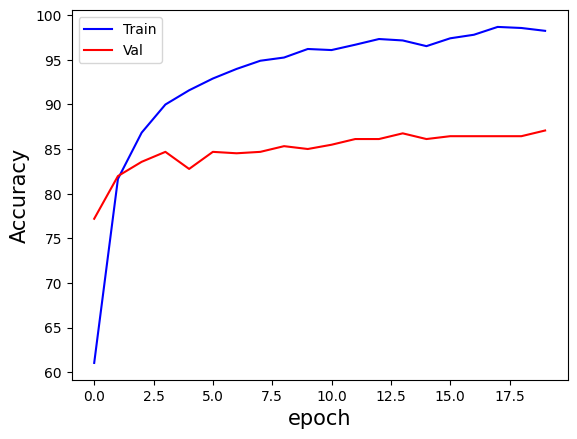

In [ ]:
plot_accuracy(VGG19_model)

#### **Insights**

1. Training Accuracy keeps increasing and reaches nearly 99%, which indicates the model is learning the training data very well.

2. Validation Accuracy improves initially but plateaus around 86–87% and stays relatively flat.

11/11 - 1s - 120ms/step - accuracy: 0.8462 - loss: 1.4565
Restored model, accuracy: 84.62%
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

Test Accuracy: 23.36%

Accuracy for class noise is 76.54% consisting of 81 images
Accuracy for class onion is 0.0% consisting of 83 images
Accuracy for class potato is 3.7% consisting of 81 images
Accuracy for class tomato is 0.0% consisting of 106 images


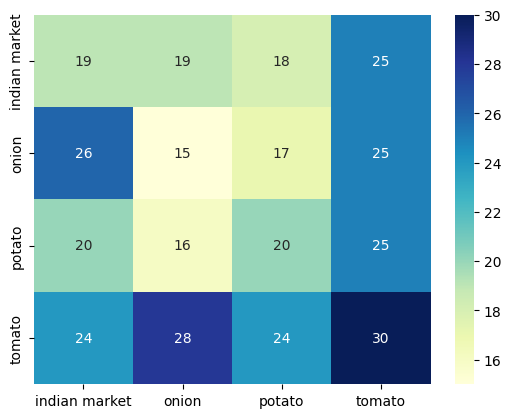

In [ ]:
model_evaluation_acc(VGG19_model)

In [ ]:
#ResNet model
pretrained_model=tf.keras.applications.ResNet101(weights='imagenet',include_top=False,input_shape=(128,128,3))
pretrained_model.trainable=False
ResNet101_model=tf.keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4,activation='softmax')
    ])
# Include 'Precision' and 'Recall' in the metrics list
ResNet101_model.compile(optimizer='Adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()], loss='categorical_crossentropy')

history=ResNet101_model.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.7330 - loss: 0.9427 - precision_1: 0.7469 - recall_1: 0.7063 - val_accuracy: 0.9155 - val_loss: 0.2348 - val_precision_1: 0.9183 - val_recall_1: 0.9139
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.9270 - loss: 0.1694 - precision_1: 0.9308 - recall_1: 0.9225 - val_accuracy: 0.9282 - val_loss: 0.1899 - val_precision_1: 0.9282 - val_recall_1: 0.9282
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9610 - loss: 0.1001 - precision_1: 0.9637 - recall_1: 0.9568 - val_accuracy: 0.9266 - val_loss: 0.1991 - val_precision_1: 0.9280 - val_recall_1: 0.9250
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9794 - loss: 0.0670 - precision_1: 0.9819 - recall_1: 0.9750 - val_accuracy: 0.9394 - val_loss: 0.1930 - val_precision_1: 0.9408 - val_recall_1: 0.9378
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9879 - loss: 0.0486 - precision_1: 0.9882 - recall_1: 0.9875 

In [ ]:
pretrained_model.summary()

Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
loss, acc,precision,recall = ResNet101_model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc),'precision:',precision,'recall:',recall)

11/11 - 2s - 156ms/step - Precision: 0.8825 - Recall: 0.8775 - accuracy: 0.8775 - loss: 0.5459
Restored model, accuracy: 87.75% precision: 0.8825215101242065 recall: 0.8774929046630859



1. Accuracy (87.75%)
  - This means 87.75% of the total predictions made by the model were correct.

2. Precision (88.25%)
  - Out of all the predictions made for the positive class, 88.25% were actually correct.

  - This is especially important when false positives are costly (e.g., classifying a rotten tomato as fresh).

3. Recall (87.75%)
  - Out of all the actual positive cases, 87.75% were successfully identified by the model.

  - High recall means the model is good at not missing relevant instances.

4. Loss (0.5459)
  - Indicates how far off the predictions are from the true labels.

  - Lower is better. This value is decent, not too high.

In [ ]:
def plot_accuracy(model_fit):
    #accuracy graph

    # Accessing the precision and recall metrics using their class names
    x = range(0,len(model_fit.history.history['precision_1']))
    y_train = [acc * 100 for acc in model_fit.history.history['precision_1']]
    y_val = [acc * 100 for acc in model_fit.history.history['recall_1']]

    plt.plot(x, y_train, label='Train', color='b')
    plt.plot(x, y_val, label='Val', color='r')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

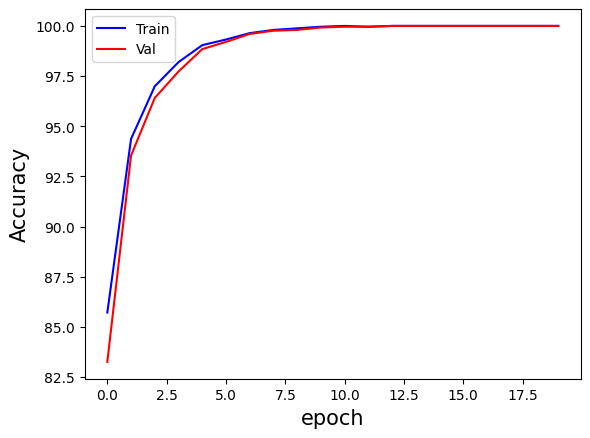

11/11 - 3s - 301ms/step - accuracy: 0.8746 - loss: 0.6005 - precision_1: 0.8746 - recall_1: 0.8746
Restored model, accuracy: 87.46% precision: 0.874643862247467 recall: 0.874643862247467
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 731ms/step

Test Accuracy: 25.64%

Accuracy for class noise is 81.48% consisting of 81 images
Accuracy for class onion is 0.0% consisting of 83 images
Accuracy for class potato is 1.23% consisting of 81 images
Accuracy for class tomato is 0.94% consisting of 106 images


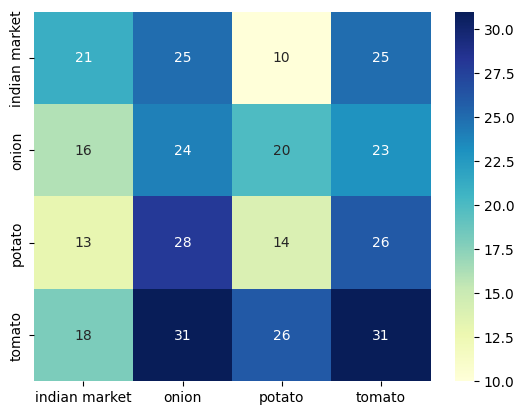

In [ ]:
plot_accuracy(ResNet101_model)
loss, acc,precision,recall = ResNet101_model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc),'precision:',precision,'recall:',recall)

y_pred = ResNet101_model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_cat = tf.concat([y for x, y in test_ds], axis=0)
true_categories = tf.argmax(true_cat, axis=1)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

classwise_accuracy(noise_path, 'noise', ResNet101_model)
classwise_accuracy(onion_path, 'onion', ResNet101_model)
classwise_accuracy(potato_path, 'potato', ResNet101_model)
classwise_accuracy(tomato_path, 'tomato', ResNet101_model)

ConfusionMatrix(cnn_model, test_ds, class_dirs)


### **Insights**
1. Blue line (Train accuracy) and Red line (Validation accuracy) follow each other very closely.

2. Both train and val accuracies reach nearly 100% by around the 10th epoch and plateau afterward.

3. No overfitting is observed — usually seen when the training accuracy is much higher than validation.

4. This means the model has learned well and is generalizing properly to unseen data.

## Testing our best model (ResNet)
  - ResNet achieved the highest accuracy of 94% among all the models we trained

  - Let's test our Finetuned ResNet to predict on some random unseen data to visualize how accurate it is

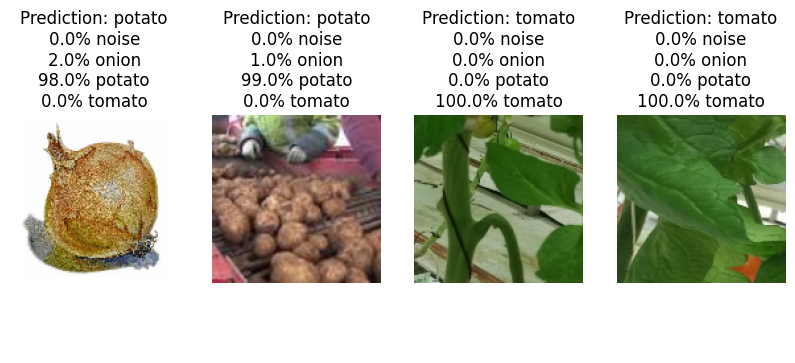

In [ ]:
grid_test_model(ResNet101_model)

1. High Model Performance

  - The model achieved ~100% train and validation accuracy, indicating it has learned the patterns in the data very well.

2. No Overfitting

  - Validation accuracy closely follows training accuracy, suggesting that the model is generalizing well and not just memorizing training data.

3. Strong Test Performance

  - On the test set, you achieved:

    - Accuracy: 87.75%

    - Precision: 88.25%

    - Recall: 87.75%

  - These scores confirm that the model performs reliably even on unseen data.

4. Well-Regularized Training

  - Use of EarlyStopping prevented unnecessary training, saving time and avoiding overfitting.

5. Efficient Use of Pretrained Models

  - Using ResNet101 and VGG16 as pretrained backbones provided strong feature extraction with minimal training effort, proving transfer learning was effective.

